<a href="https://colab.research.google.com/github/elifsare/Real-time-Age-Gender-Ethnicity-Detection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
!ls

Mounted at /content/drive
drive  sample_data


In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 96% 61.0M/63.2M [00:03<00:00, 24.7MB/s]
100% 63.2M/63.2M [00:03<00:00, 17.9MB/s]


In [4]:
!mkdir dataset

In [5]:
!unzip '/content/age-gender-and-ethnicity-face-data-csv.zip' -d dataset

Archive:  /content/age-gender-and-ethnicity-face-data-csv.zip
  inflating: dataset/age_gender.csv  


In [6]:
import numpy as np 
import pandas as pd

import tensorflow as tf
from keras.models import Sequential     
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dropout, AveragePooling2D, Activation, BatchNormalization
from keras.optimizers import SGD, Adam, RMSprop, Adamax 
from keras.utils import np_utils  
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('/content/dataset/age_gender.csv')

In [8]:
## Converting pixels into numpy array
num_pixels = len(df['pixels'][0].split(" "))
img_height = int(np.sqrt(len(df['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(df['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)

2304 48 48


In [9]:
df['pixels'] = df['pixels'].apply(lambda x: np.array(x.split(),dtype='float32'))

data visulate

In [10]:
df1 = df.drop('img_name', axis=1)
y1 = df1.drop("pixels", axis=1)

In [11]:
y1.nunique()

age          104
ethnicity      5
gender         2
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


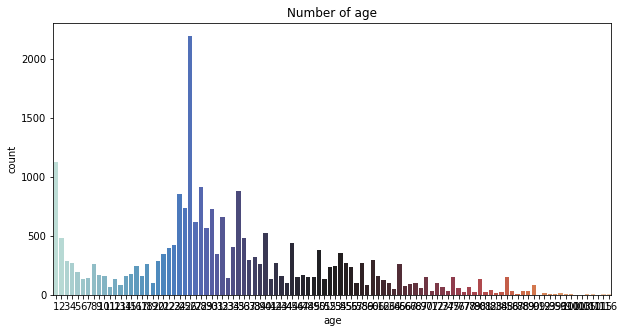

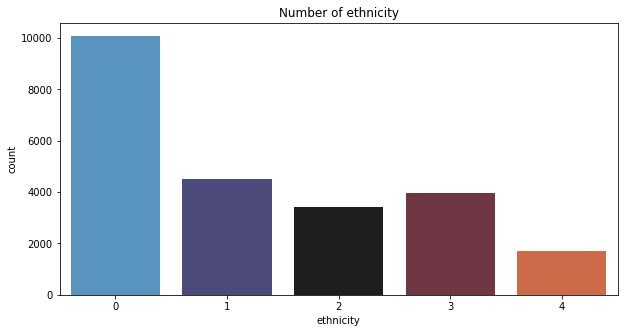

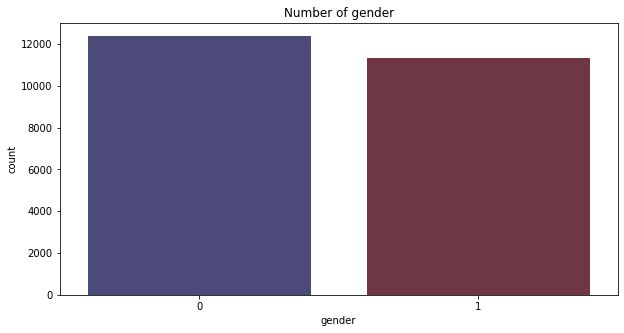

In [12]:
import seaborn as sns
for i in y1.columns:
    plt.figure(figsize=(10,5))
    g = sns.countplot(y1[i], palette="icefire")
    plt.title("Number of {}".format(i))

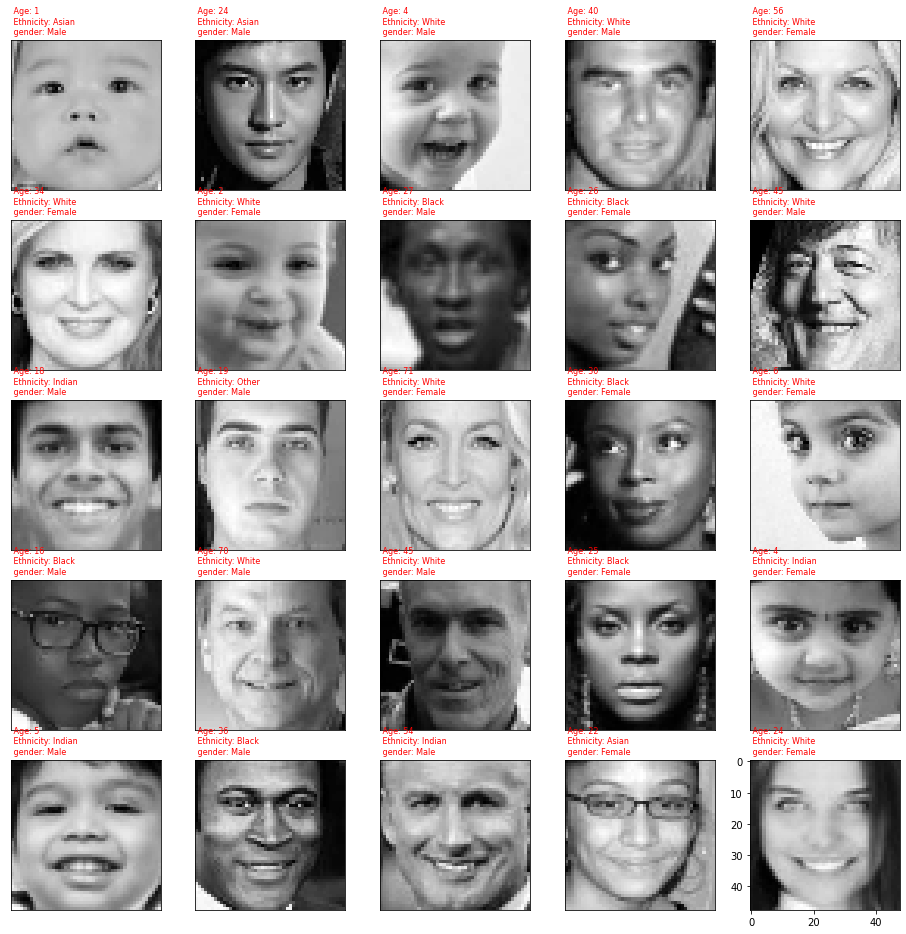

In [13]:
plt.figure(figsize=(16, 16))

for i in range(25):  
    index = np.random.randint(0, len(df))
    plt.xticks([])
    plt.yticks([])   
    plt.grid(False)
    plt.subplot(5, 5, i+1)
    plt.imshow(df['pixels'].iloc[index].reshape(48, 48),"gray")
    plt.title(' Age: {}\n Ethnicity: {}\n gender: {}'.format(df['age'].iloc[index], {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Other"}[df['ethnicity'].iloc[index]], {0:"Male", 1:"Female"}[df['gender'].iloc[index]]),loc="left",color='red',fontsize = 8)

plt.show()

In [14]:
X = np.array(df['pixels'].tolist())
X = np.reshape(X, (-1, 48, 48,1))

In [15]:
def m_subplot(h):
  plt.figure(figsize = (14,3))
  plt.subplot(1,2,1)
  plt.ylabel('Loss', fontsize = 15)
  plt.plot(h.history['loss'], color = 'b', label = 'Training Loss')
  plt.plot(h.history['val_loss'], color = 'r', label = 'Validation Loss')

  plt.subplot(1,2,2)
  plt.ylabel('Accuracy', fontsize = 15)
  plt.plot(h.history['accuracy'], color = 'b', label = 'Training Accuracy')
  plt.plot(h.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

  plt.legend(loc = 'lower right')

  plt.show()

# Age Model

In [16]:
y = df['age']
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X, y, test_size=0.3, random_state=30)

image generetor

In [17]:
train_generator = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    rescale = 1./255,
                                    validation_split = 0.2
                                    )
validation_generator = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [18]:
train_flow_age = train_generator.flow(X_test_age,
                                  y_test_age,
                                  batch_size=32)

validation_flow_age = validation_generator.flow(X_test_age,
                                            y_test_age,
                                            batch_size=32)

In [19]:
model_age = Sequential()

model_age.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))

model_age.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_age.add(BatchNormalization())
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Conv2D(64, (3, 3), activation='relu'))
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Conv2D(128, (3, 3), activation='relu'))
model_age.add(MaxPooling2D((2, 2)))

model_age.add(Flatten())

model_age.add(Dense(64, activation='relu'))
model_age.add(Dropout(rate=0.2))

model_age.add(Dense(1, activation = 'relu'))

model_age.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['mae'])


model_age.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

In [20]:
root = '/content/drive/MyDrive/DeepLearningProject/Gender&Age/'
checkPointer = ModelCheckpoint(root + 'checkPoint_model_age.h5', verbose = 1, save_best_only = True)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [22]:
batch_size = 64
epochs = 60

In [23]:
h_age = model_age.fit(train_flow_age, 
                      epochs= epochs,
                      batch_size=batch_size,
                      validation_split=0.1,
                      validation_data= validation_flow_age,
                      callbacks= callbacks_list)

Epoch 1/60
223/223 [==============================] - ETA: 0s - loss: 376.5399 - mae: 14.8069
Epoch 1: val_loss improved from inf to 1198.07153, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5
223/223 [==============================] - 15s 29ms/step - loss: 376.5399 - mae: 14.8069 - val_loss: 1198.0715 - val_mae: 29.0575 - lr: 0.0010
Epoch 2/60
223/223 [==============================] - ETA: 0s - loss: 266.3578 - mae: 12.5883
Epoch 2: val_loss improved from 1198.07153 to 709.56976, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_age.h5
223/223 [==============================] - 5s 24ms/step - loss: 266.3578 - mae: 12.5883 - val_loss: 709.5698 - val_mae: 21.4622 - lr: 0.0010
Epoch 3/60
222/223 [============================>.] - ETA: 0s - loss: 214.8915 - mae: 11.1254
Epoch 3: val_loss improved from 709.56976 to 287.97174, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_m

In [24]:
train_loss, train_acc = model_age.evaluate(train_flow_age)
test_loss, test_acc   = model_age.evaluate(validation_flow_age)

223/223 [==============================] - 1s 5ms/step - loss: 79.4142 - mae: 6.5592


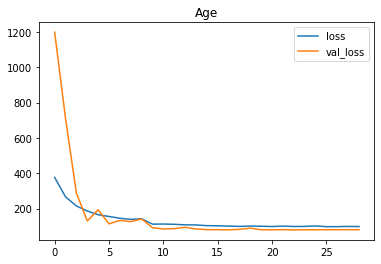

In [25]:
losses_age = pd.DataFrame(h_age.history)
losses_age[['loss','val_loss']].plot(title='Age')

# Gender Model

In [26]:
y = df['gender']
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X,
                                                                                y, 
                                                                                test_size=0.3, 
                                                                                random_state=40)

image generetor

In [27]:
batch_size = 64
epoch = 60

In [28]:
train_flow_gender = train_generator.flow(X_test_gender,
                                  y_test_gender,
                                  batch_size=batch_size)

validation_flow_gender = validation_generator.flow(X_test_gender,
                                            y_test_gender,
                                            batch_size=batch_size)

In [29]:
model_gender = Sequential()

model_gender.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model_gender.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_gender.add(BatchNormalization())
model_gender.add(MaxPooling2D((2, 2)))

model_gender.add(Conv2D(64, (3, 3), activation='relu'))
model_gender.add(MaxPooling2D((2, 2)))

model_gender.add(Flatten())

model_gender.add(Dense(64, activation='relu'))
model_gender.add(Dropout(rate=0.5))
model_gender.add(Dense(1, activation='sigmoid'))

model_gender.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_gender.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 64)      

In [30]:
checkPointer = ModelCheckpoint(root + 'checkPoint_model_gender.h5', verbose = 1, save_best_only = True)

In [31]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [32]:
h_gender = model_gender.fit(train_flow_gender, 
                            epochs= epochs,
                            batch_size = batch_size,
                            validation_split=0.1,
                            validation_data= validation_flow_gender,
                            callbacks= callbacks_list)

Epoch 1/60
111/112 [============================>.] - ETA: 0s - loss: 0.6386 - accuracy: 0.6335
Epoch 1: val_loss improved from inf to 0.67804, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_gender.h5
112/112 [==============================] - 6s 47ms/step - loss: 0.6379 - accuracy: 0.6340 - val_loss: 0.6780 - val_accuracy: 0.7056 - lr: 0.0100
Epoch 2/60
112/112 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.6939
Epoch 2: val_loss improved from 0.67804 to 0.64641, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_gender.h5
112/112 [==============================] - 4s 40ms/step - loss: 0.5913 - accuracy: 0.6939 - val_loss: 0.6464 - val_accuracy: 0.7383 - lr: 0.0100
Epoch 3/60
112/112 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.7123
Epoch 3: val_loss improved from 0.64641 to 0.60424, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkP

In [33]:
train_loss, train_acc = model_gender.evaluate(train_flow_gender)
test_loss, test_acc   = model_gender.evaluate(validation_flow_gender)

112/112 [==============================] - 1s 7ms/step - loss: 0.3040 - accuracy: 0.8636


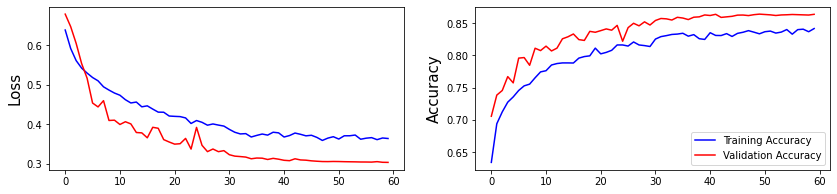

In [34]:
m_subplot(h_gender)

# Ethnicity model

In [35]:
y = df['ethnicity']

In [36]:
X_train_ethnicity, X_test_ethnicity, y_train_ethnicity, y_test_ethnicity = train_test_split(X,
                                                                                            y,
                                                                                            test_size = 0.3,
                                                                                            random_state = 40)

image generetor

In [37]:
train_flow_ethnicity = train_generator.flow(X_test_ethnicity,
                                            y_test_ethnicity,
                                            batch_size=32)

validation_flow_ethnicity= validation_generator.flow(X_test_ethnicity,
                                                     y_test_ethnicity,
                                                     batch_size=32)

In [38]:
model_ethnicity = Sequential()

model_ethnicity.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))

model_ethnicity.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_ethnicity.add(MaxPooling2D((2, 2)))

model_ethnicity.add(Conv2D(64, (3, 3), activation='relu'))
model_ethnicity.add(MaxPooling2D((2, 2)))

model_ethnicity.add(Flatten())

model_ethnicity.add(Dense(64, activation='relu'))
model_ethnicity.add(Dropout(rate=0.2))

model_ethnicity.add(Dense(5))

model_ethnicity.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model_ethnicity.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6400)             

In [39]:
checkPointer = ModelCheckpoint(root + 'checkPoint_model_ethnicity.h5', verbose = 1, save_best_only = True)

In [40]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=6,
                               verbose=1,
                               restore_best_weights=True)

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.2,
                                        patience=3,
                                        verbose=1,
                                        min_delta=0.0001)

callbacks_list = [early_stopping, checkPointer, reduce_learningrate]

In [41]:
h_ethnicity = model_ethnicity.fit(train_flow_ethnicity, 
                                  epochs= epochs,
                                  batch_size=batch_size,
                                  validation_split=0.1,
                                  validation_data= validation_flow_ethnicity,
                                  callbacks= callbacks_list)

Epoch 1/60
222/223 [============================>.] - ETA: 0s - loss: 1.3961 - accuracy: 0.4463
Epoch 1: val_loss improved from inf to 1.22727, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_ethnicity.h5
223/223 [==============================] - 6s 24ms/step - loss: 1.3957 - accuracy: 0.4467 - val_loss: 1.2273 - val_accuracy: 0.5145 - lr: 0.0010
Epoch 2/60
222/223 [============================>.] - ETA: 0s - loss: 1.2505 - accuracy: 0.5158
Epoch 2: val_loss improved from 1.22727 to 1.03782, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/checkPoint_model_ethnicity.h5
223/223 [==============================] - 5s 24ms/step - loss: 1.2495 - accuracy: 0.5162 - val_loss: 1.0378 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 3/60
221/223 [============================>.] - ETA: 0s - loss: 1.1354 - accuracy: 0.5637
Epoch 3: val_loss improved from 1.03782 to 1.00266, saving model to /content/drive/MyDrive/DeepLearningProject/Gender&Age/

In [42]:
train_loss, train_acc = model_ethnicity.evaluate(train_flow_ethnicity)
test_loss, test_acc   = model_ethnicity.evaluate(validation_flow_ethnicity)

223/223 [==============================] - 1s 5ms/step - loss: 0.5376 - accuracy: 0.8113


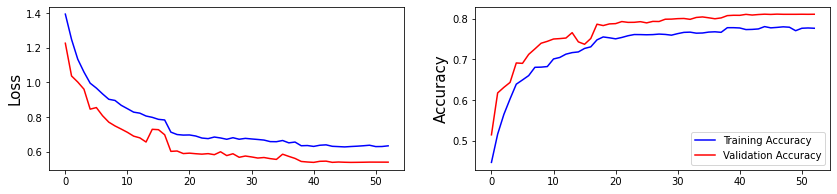

In [43]:
m_subplot(h_ethnicity)